In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2'
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
assert len(physical_devices) == 3
# to allow other tensorflow processes to use the gpu
# https://stackoverflow.com/a/60699372/7989988
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)
tf.config.experimental.set_memory_growth(physical_devices[2], True)

import numpy as np
from tensorflow import keras
from tensorflow.keras import Model, Input, layers
from IPython.display import display
import tensorflow_datasets as tfds
import time
import matplotlib.pyplot as plt
import enlighten
import tensorflow_probability as tfp
from dotmap import DotMap

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]


In [2]:
import models
import training
import datasets
import vizualization
import schedules

# todo
# - combine shuffled and unshuffled datasets into same thing
# - add extra shuffled indices and noise
# - add "noise fraction" parameter which can be changed the same way as the "n" parameter.
# - add different amounts of noise to the data and see what happens

In [3]:
config = DotMap({
    'ds': 'mnist',
    'distributed': True,
    'minibatch_size': 8,
    'n_steps': 120001,
    'test_size': 300,
    'test_minibatch_size': 25,
    'test_interval': 500,
    'test_n_shuf': [392, 1, 64, 128, 256],
    'test_n_seq': [392, 1, 128, 256, 512],
    'test_autoregressive': False,
    'noise_fraction': 0,
    'display_images': True,
    'display_image_interval': 5000,
    'dont_display_until_loss': 0.48,
    'bg_color': [1.0, 0.4, 0.6],
    'lr_schedule': ['constant', 0.0004],
    'lr_warmup': 100,
    'grad_accum_steps': None, #['exponential', 1, 4],
    'max_accum_steps': 4,
    'use_wandb': True,
    'wandb_log_interval': 10,
    'loss_window_size': 80,
    'kmeans_batch_size': 1000,
})

# need to change for multiworkerstrategy
if config.distributed:
    config.num_devices = len(physical_devices)
else:
    config.num_devices = 1
config.global_batch_size = config.minibatch_size * config.num_devices

Example integers sampled from gamma distribution.
tf.Tensor(
[ 75  19 116 164 346 163 377  61 403 189 286 182  61 182 783 187 155 207
 109 377   7 148 605 367  20  91 137  49 422 102  24  98 627 233 228 369
  91 159   6  13  98 248  86 194 379 479 160  29 302 167  15  71 225 230
  62 407 369 108 299  53  46 150  77   8  92 122 134 284 103 193 139  81
 727 461  40 238 107  97 300 564 710 152 206 120  28 222  96  79 330 289
 295 100  25   5 141 463  10 411 183  99], shape=(100,), dtype=int32)


centroids.shape (4, 1)


Not using gradient accumulation


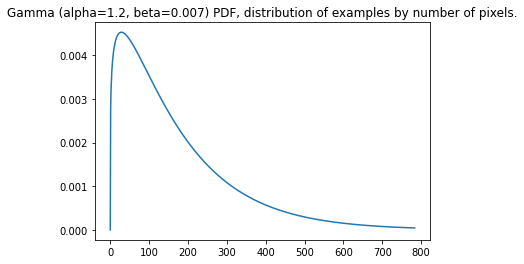

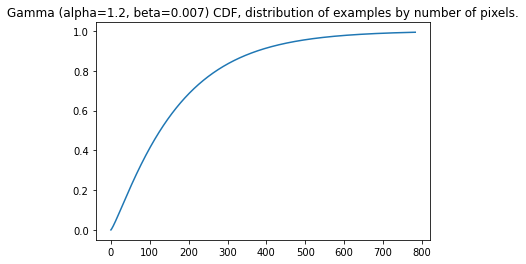

In [4]:
# idea is to not have to re-run this cell for subsequent training runs unless the centroids change

ds_configs = DotMap({
    'mnist': {
        'buffer_size': 60000,
        'name': 'mnist',
        'n_colors': 4,
        'n_color_dims': 1,
        'image_size': (28, 28),
    },
    'mnist_7x7': {
        'buffer_size': 60000,
        'name': 'mnist',
        'n_colors': 4,
        'n_color_dims': 1,
        'rescale': (7, 7),
    },
    'mnist_binary_7x7': {
        'buffer_size': 60000,
        'name': 'mnist',
        'n_colors': 2,
        'n_color_dims': 1,
        'rescale': (7, 7),
    },
    'celeb': {
        'name': 'celeb_a',
        'buffer_size': 10000,
        'n_colors': 16,
        'n_color_dims': 3,
        'image_size': (218, 178),
        'rescale': (32, 39),
    }
})

config.dataset = ds_configs[config.ds]
config.dataset.seq_length = config.dataset.image_size[0]*config.dataset.image_size[1]*config.dataset.n_color_dims
gamma_dist, gamma_name = datasets.mnist_gamma_distribution()
datasets.plot_distribution(config, gamma_dist, gamma_name)

dataset, metadata = tfds.load(config.dataset.name, with_info=True, as_supervised=True)

ds_train_original = dataset['train']
ds_test_original = dataset['test']

centroids = datasets.find_centroids(config, ds_train_original)

ds = datasets.Datasets(config, ds_train_original, ds_test_original, centroids, gamma_dist)
viz = vizualization.Viz(config, ds, centroids)
ds_train, ds_test = ds.make_datasets()


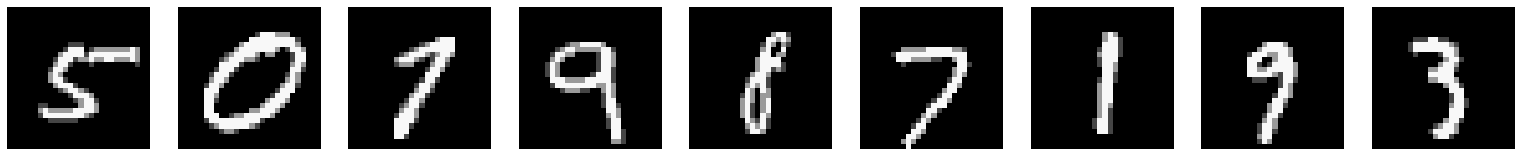

In [5]:
display_colors, display_idxs, *_ = next(iter(ds_train))
if config.grad_accum_steps:
    display_colors,display_idxs = display_colors[0],display_idxs[0]
viz.showSeq(display_colors, display_idxs, config.dataset.image_size, max_images=9)

In [6]:


# model config
config.model = DotMap({
    'n_colors': config.dataset.n_colors,
    'n_color_dims': config.dataset.n_color_dims,
    'image_size': config.dataset.image_size,
    'seq_len': config.dataset.image_size[0] * config.dataset.image_size[1],
    'n_enc_a_layers': 6,
    'n_enc_b_layers': 3,
    'ffl_dim': 1024,
    'embd_dim': 512,
    'n_dec_layers': 2,
    'dec_dim': 400,
    'n_heads': 8,
    'dropout_rate': 0.1,
    'use_idxs_input': True,
    'architecture': 'anp',
    'position_embedding': 'pos_enc',
    'activation': 'swish',
})

if config.distributed == False:
    strategy = tf.distribute.get_strategy()
else:
    strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = models.transformer(config.model)
    # Adam params taken from the linked notebook
    optimizer = keras.optimizers.Adam(learning_rate=schedules.learning_rate_schedule(config))

ds_train_dist = strategy.experimental_distribute_dataset(ds_train)

config.training_mode = 'full_combination'

import socket
model_name = models.model_name(socket.gethostname(), config)
print(model_name)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


cuda5.ecs.vuw.ac.nz-28x28-bs3x1x8


In [7]:
evaler = training.Evaluator(config, model, optimizer, viz, ds, ds_train_dist, ds_test)

training_loop = training.TrainingLoop(config, evaler, model_name)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: maxeonyx (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/home/clarkemaxw/.cache/pypoetry/virtualenvs/msc-Wq9zJYZB-py3.8/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("StatefulPartitionedCall:2", shape=(None,), dtype=int32), values=Tensor("StatefulPartitionedCall:1", shape=(None, 512), dtype=float32), dense_shape=Tensor("StatefulPartitionedCall:3", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/clarkemaxw/.cache/pypoetry/virtualenvs/msc-Wq9zJYZB-py3.8/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("StatefulPartitionedCall_1:2", shape=(None,), dtype=int32), values=Tensor("StatefulPartitionedCall_1:1", shape=(None, 512), dtype=float32), dense_shape=Tensor("StatefulPartitionedCall_1:3", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This m

INFO:tensorflow:batch_all_reduce: 153 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 153 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 153 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 153 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Step 0, Loss (last minibatch): 8.054450988769531, Loss (80 step avg.): 8.054450988769531


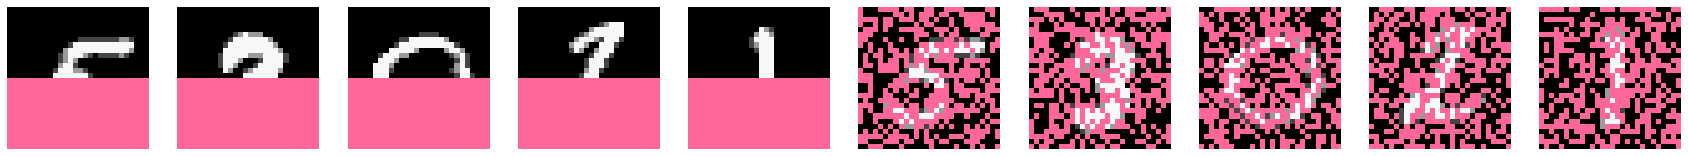

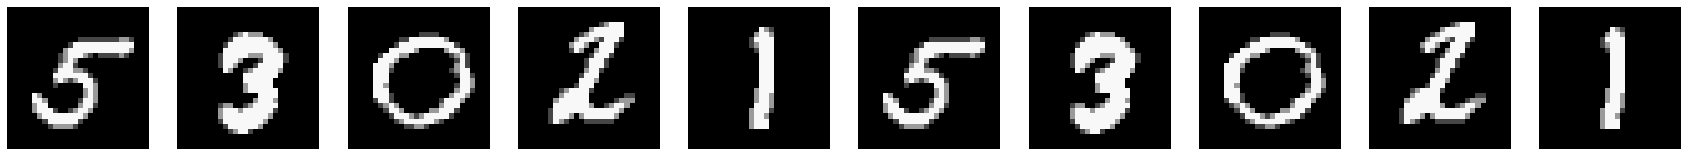

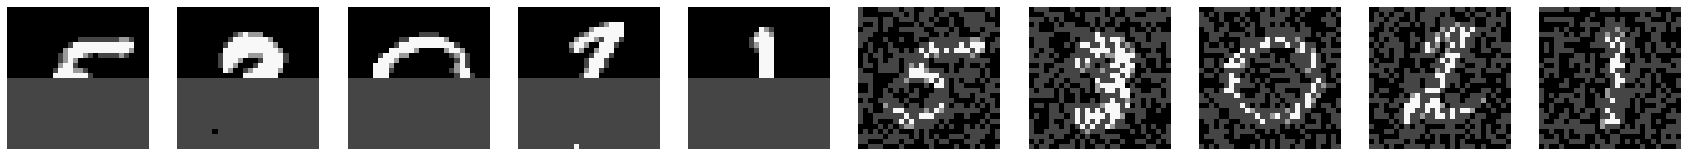

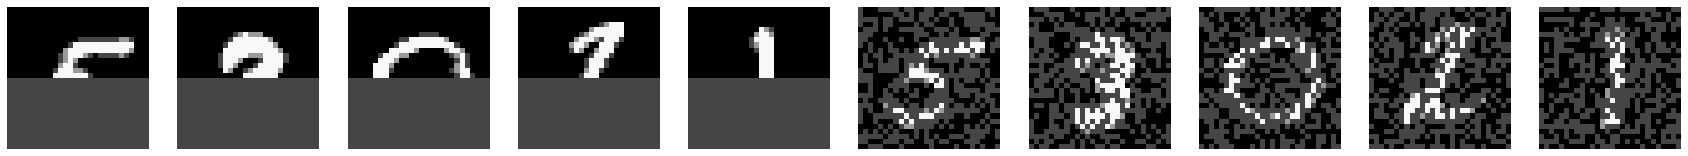

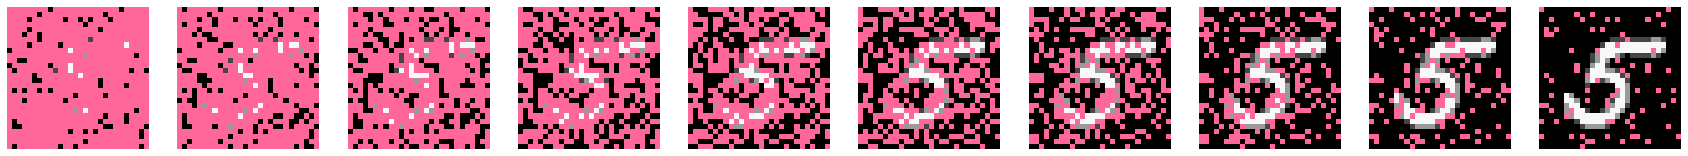

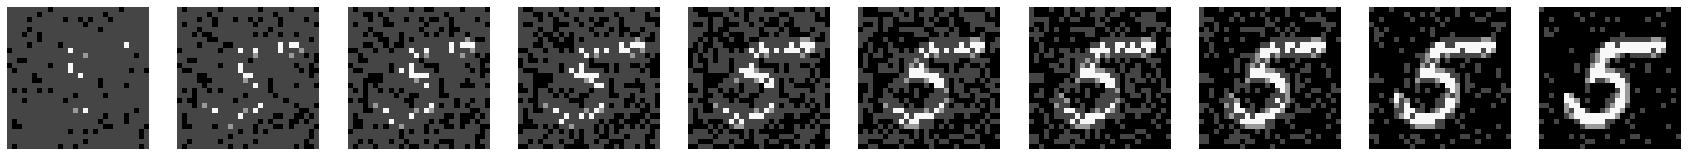

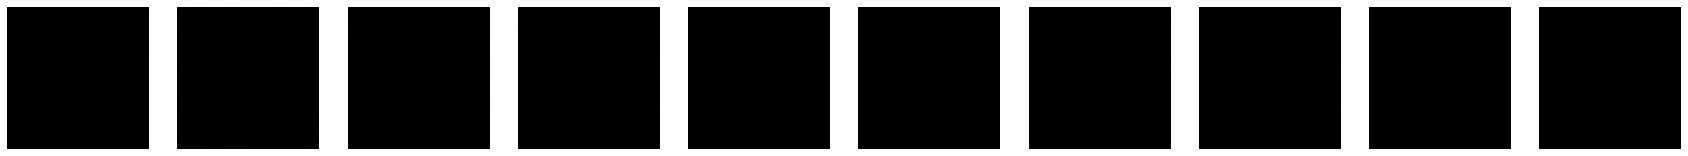

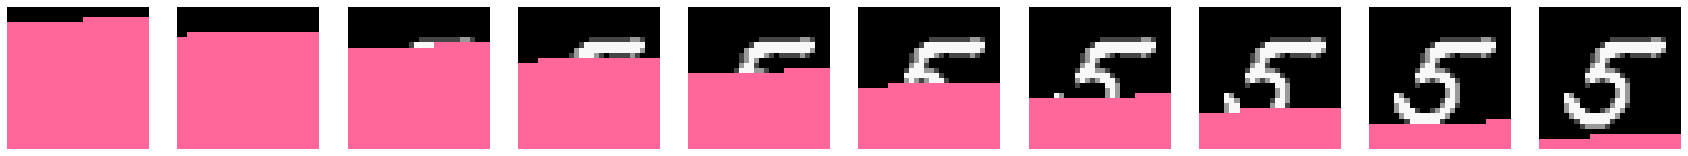

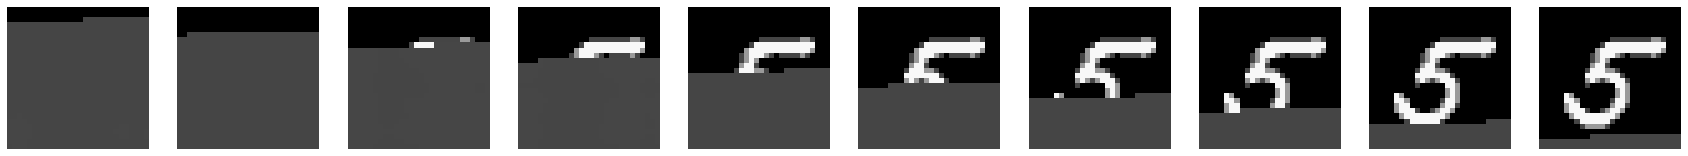

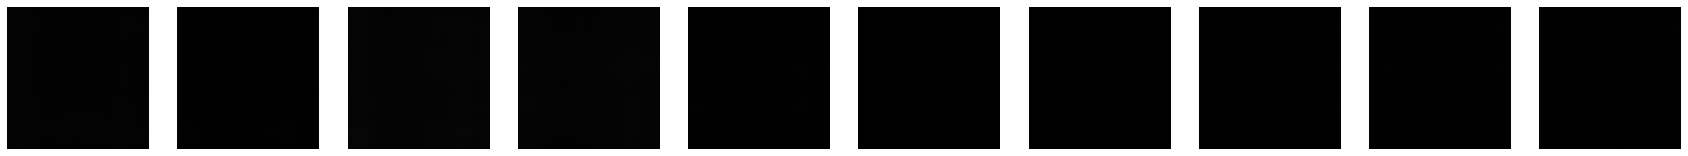

Step 122, Loss (last minibatch): 0.43139931559562683, Loss (80 step avg.): 0.47973937164118263


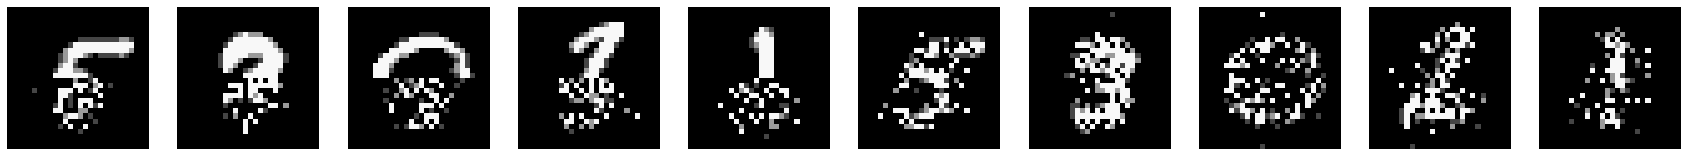

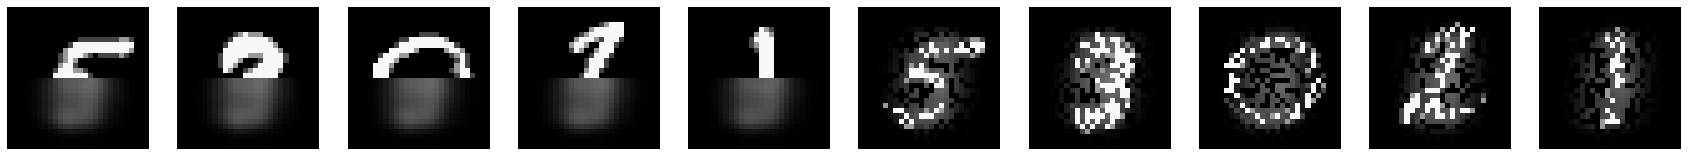

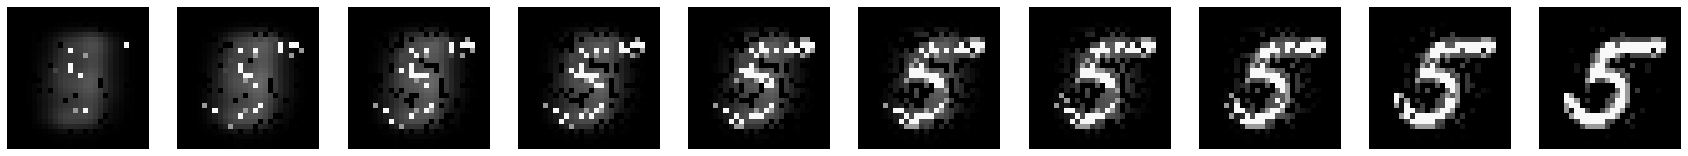

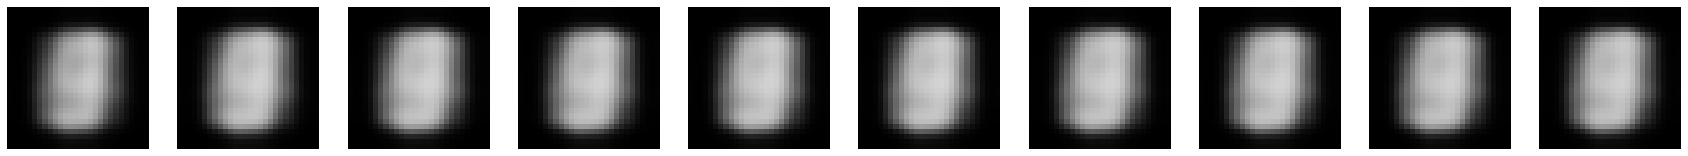

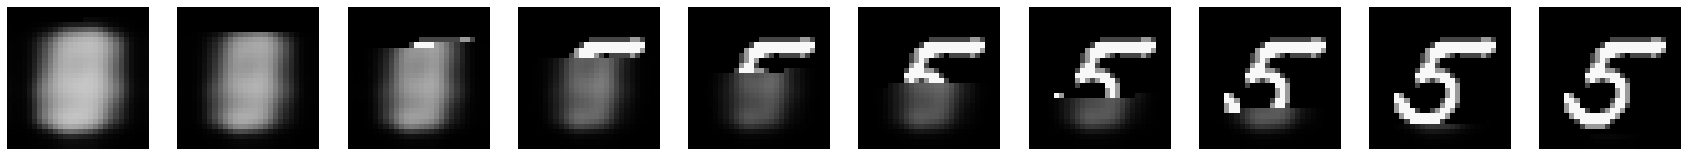

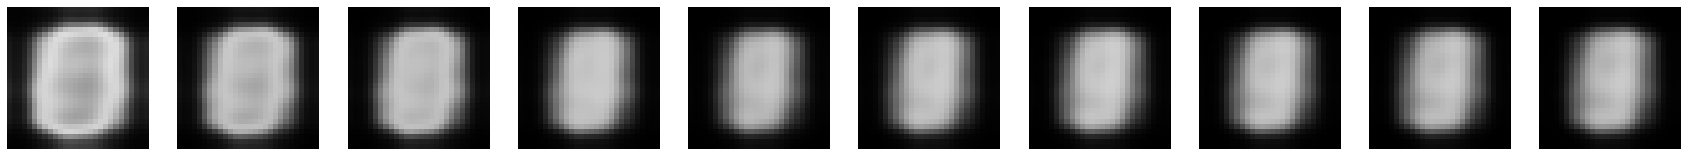

Step 958, Loss (last minibatch): 0.36336347460746765, Loss (80 step avg.): 0.43152163131737414


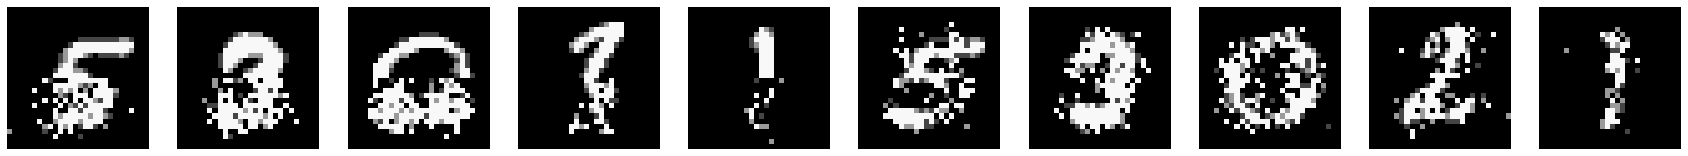

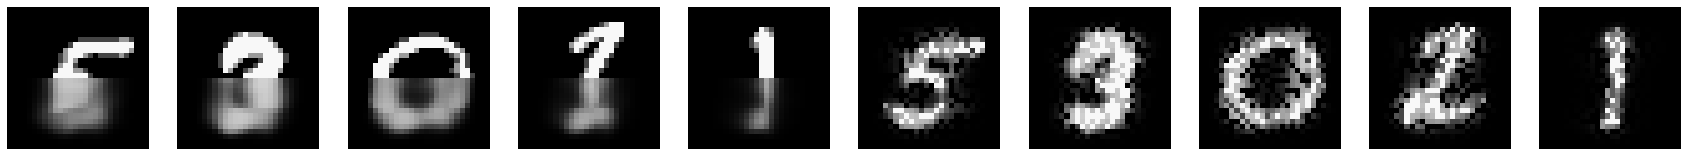

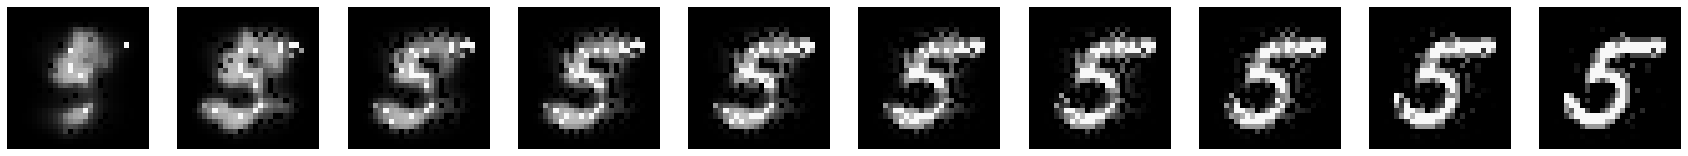

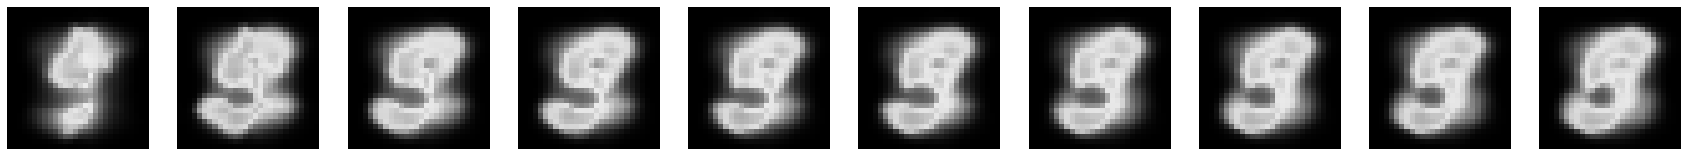

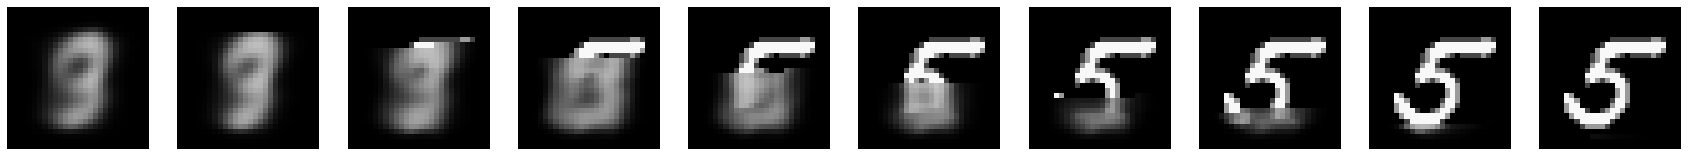

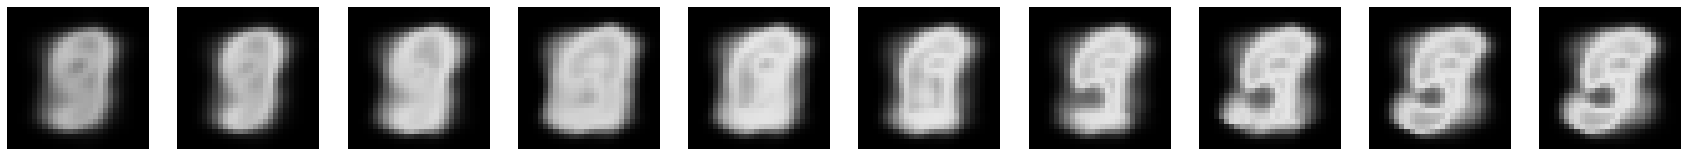

Step 999, Loss (last minibatch): 0.2629699110984802, Loss (80 step avg.): 0.3871813515822093


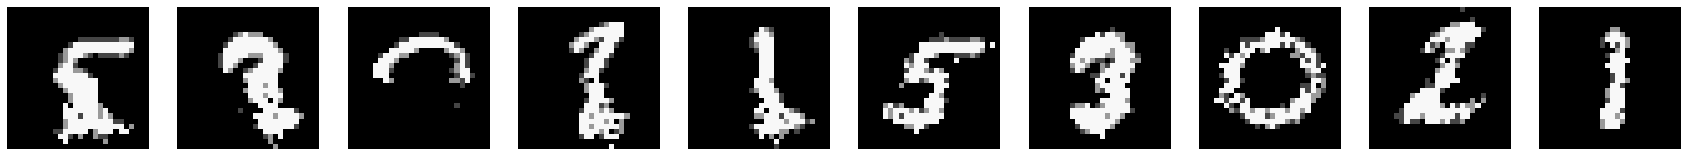

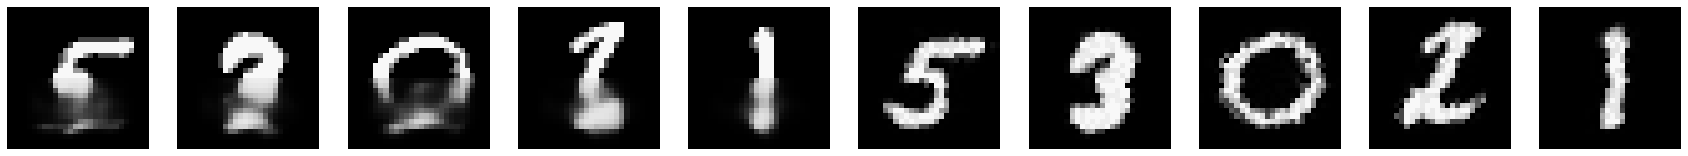

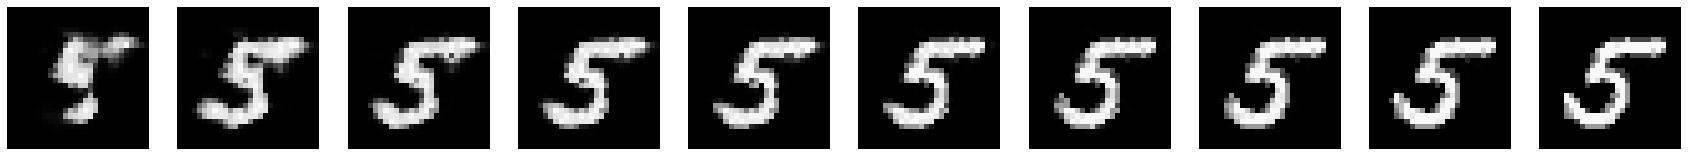

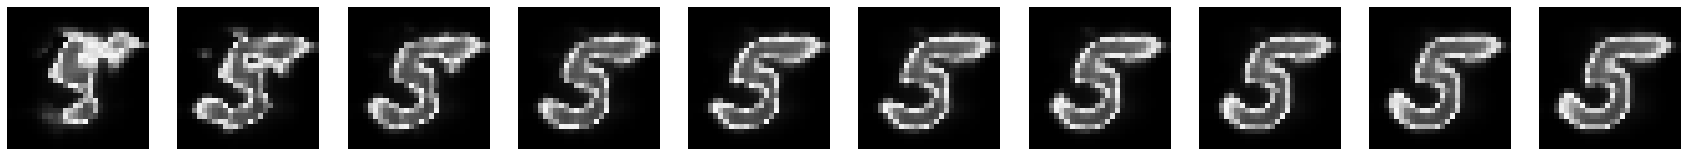

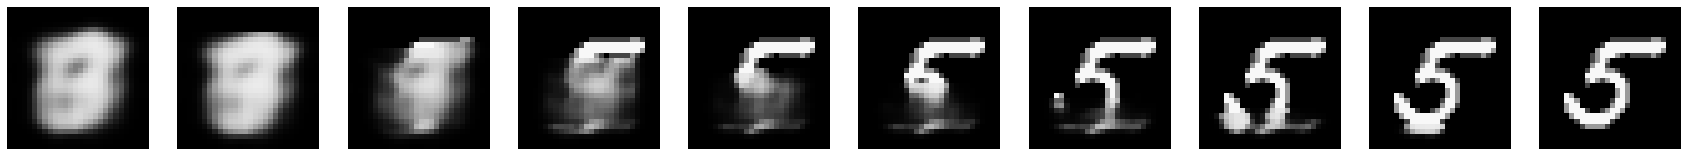

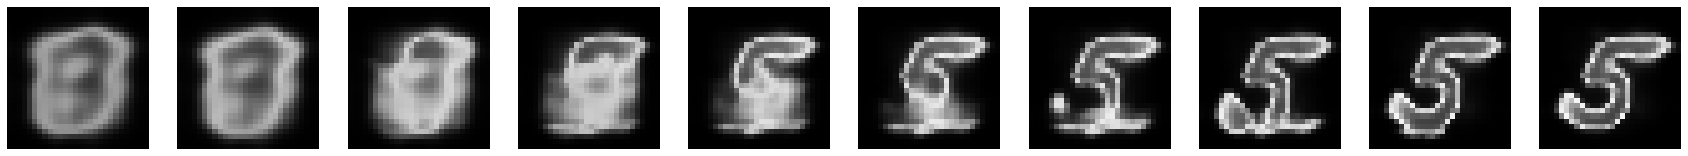

Step 1029, Loss (last minibatch): 0.2545442283153534, Loss (80 step avg.): 0.3405718211038613


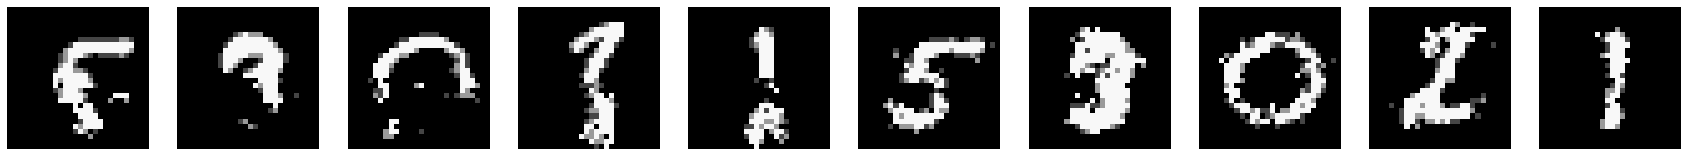

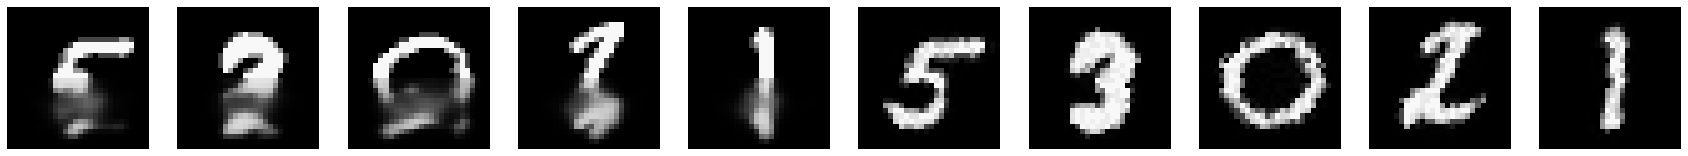

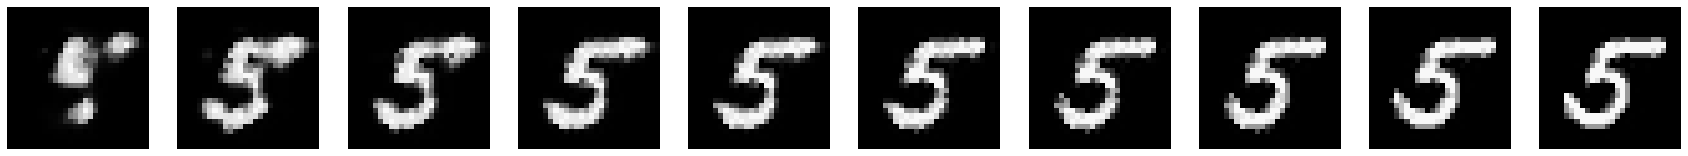

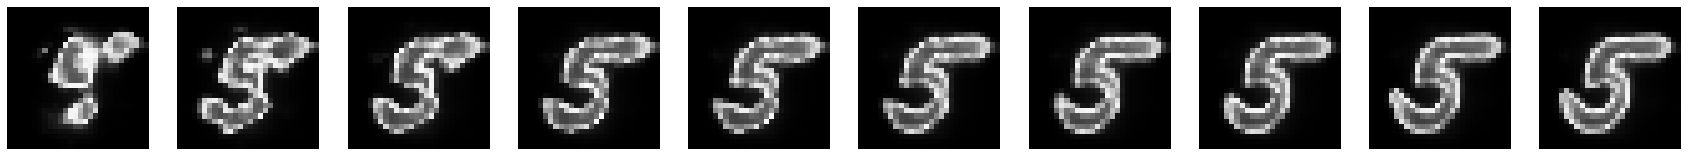

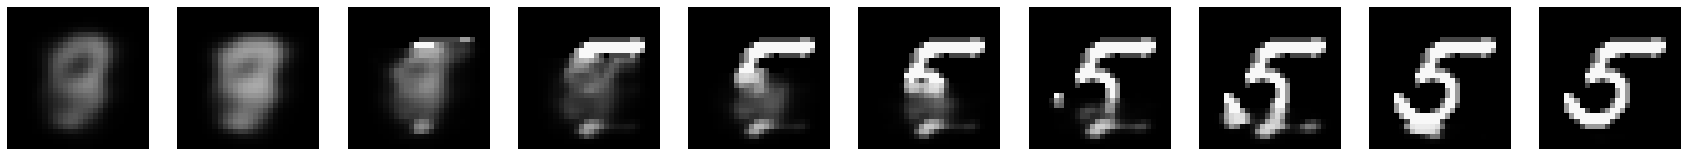

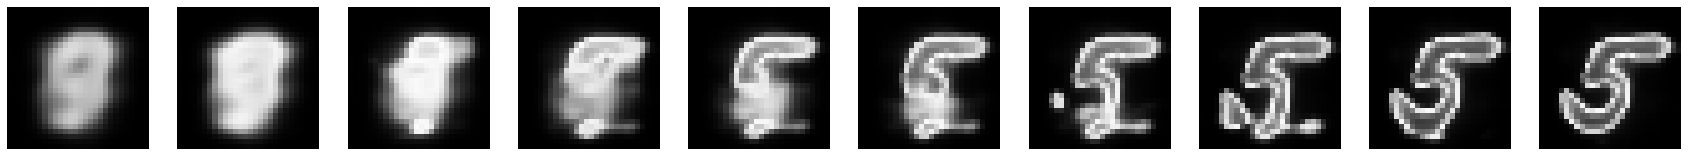

Step 1062, Loss (last minibatch): 0.21736332774162292, Loss (80 step avg.): 0.305670533835152


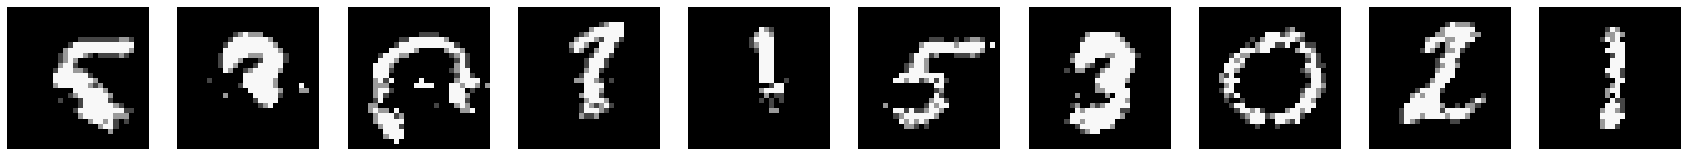

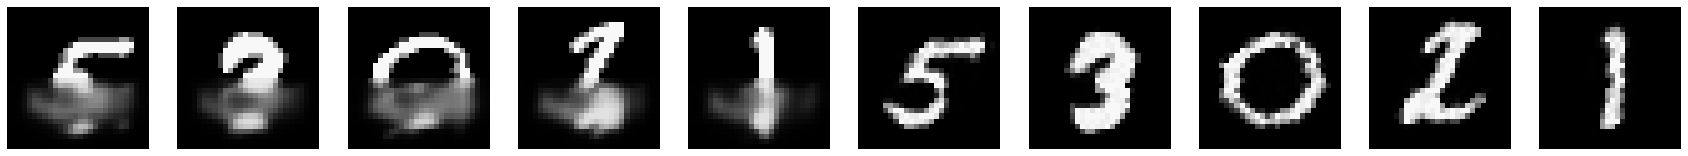

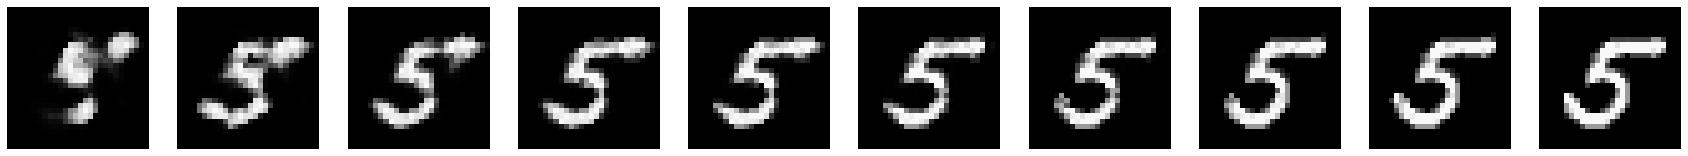

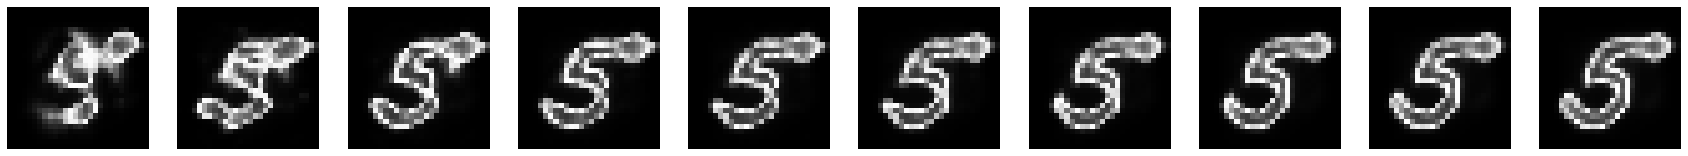

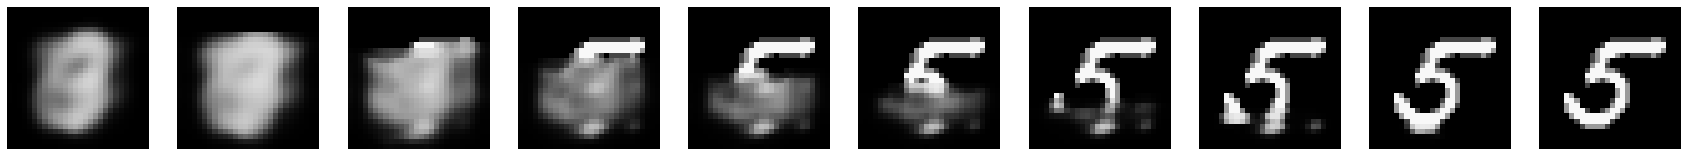

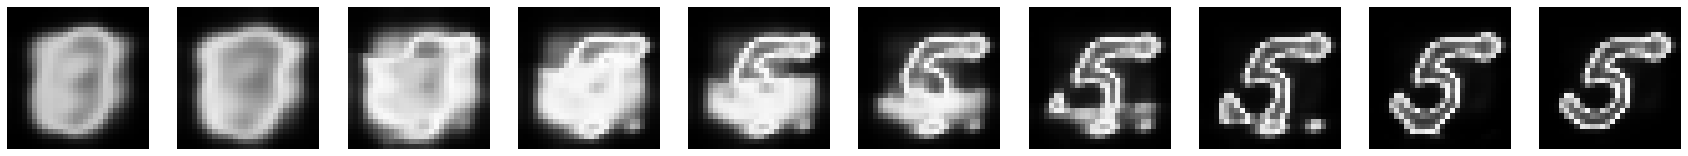

Step 1139, Loss (last minibatch): 0.2350117564201355, Loss (80 step avg.): 0.27507267027725407


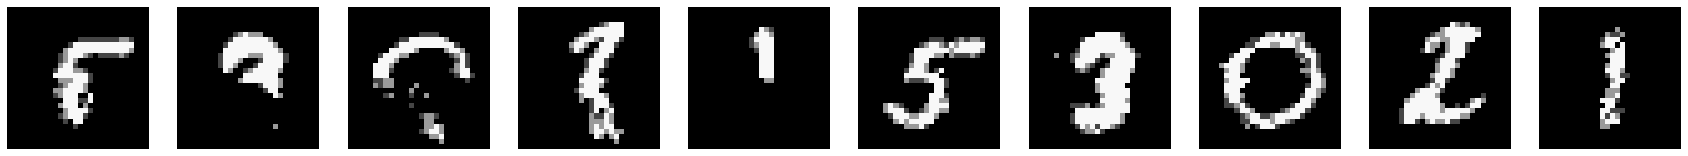

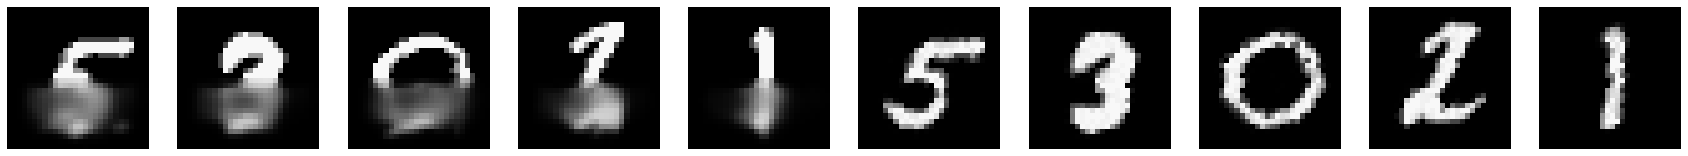

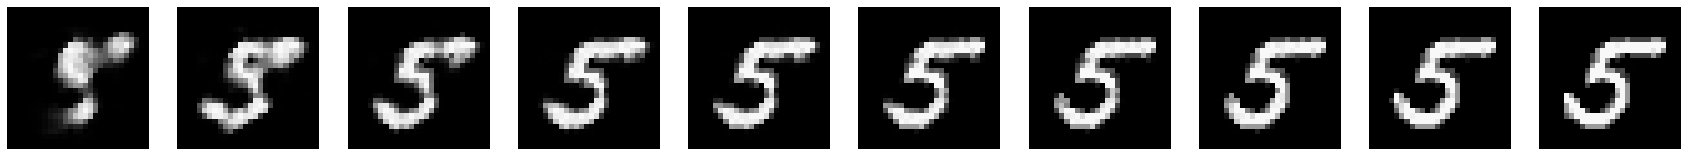

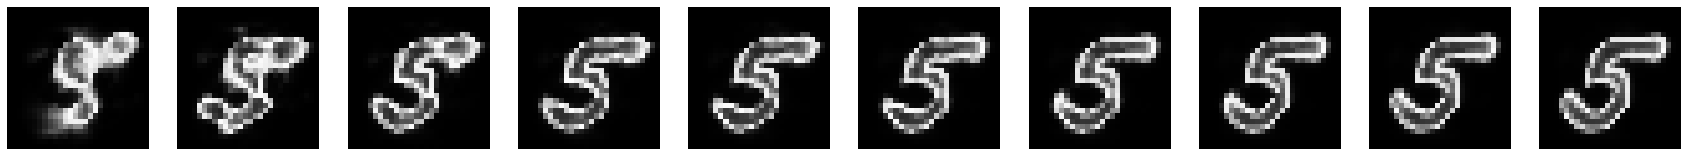

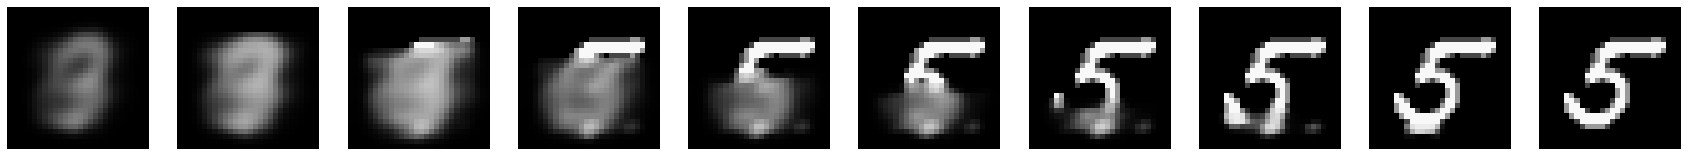

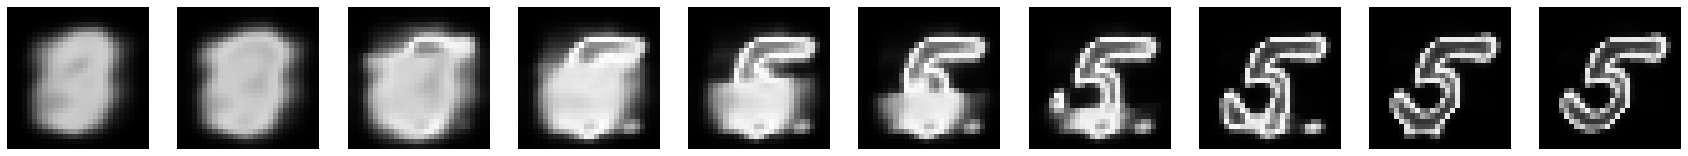

Step 1605, Loss (last minibatch): 0.18409191071987152, Loss (80 step avg.): 0.24752046296625962


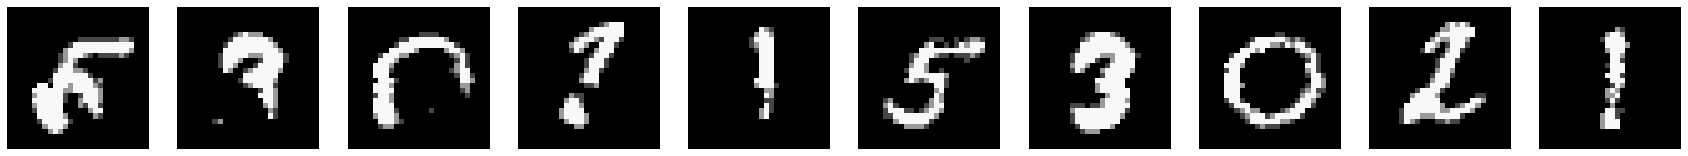

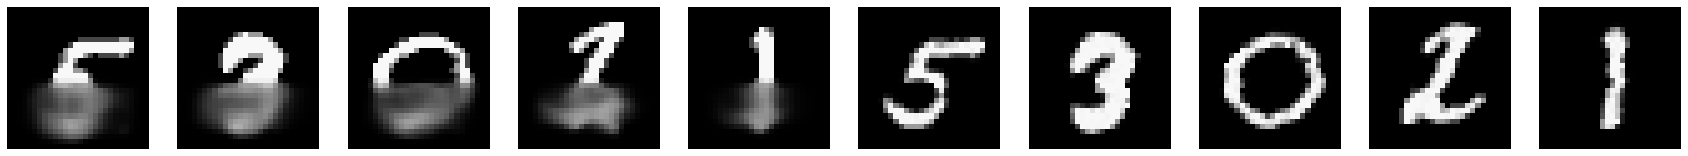

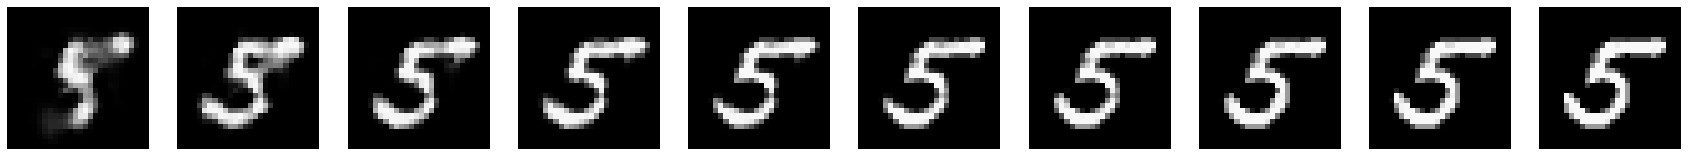

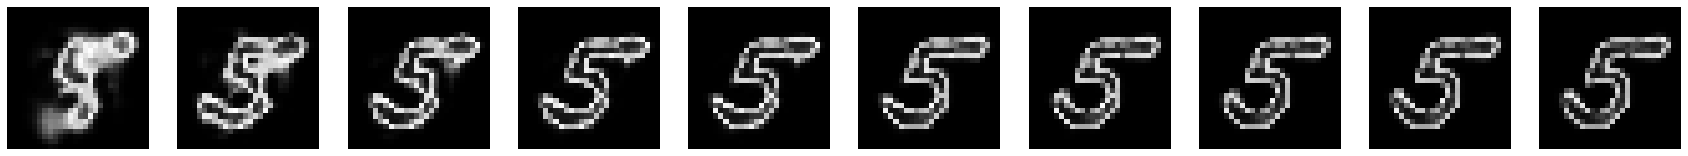

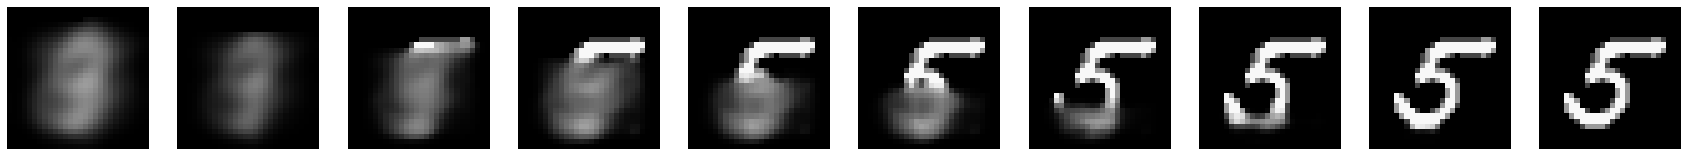

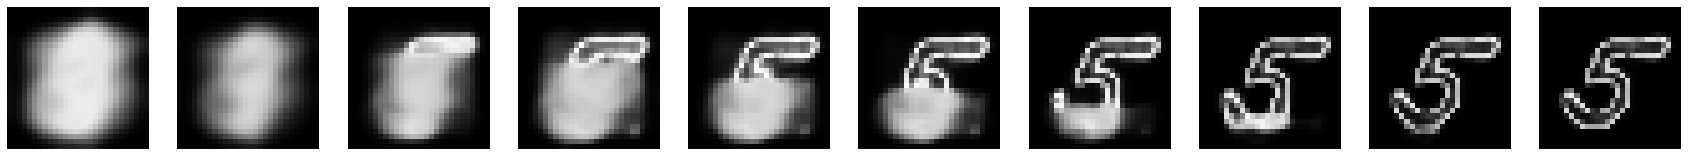

Step 2180, Loss (last minibatch): 0.14672218263149261, Loss (80 step avg.): 0.22209527021572914


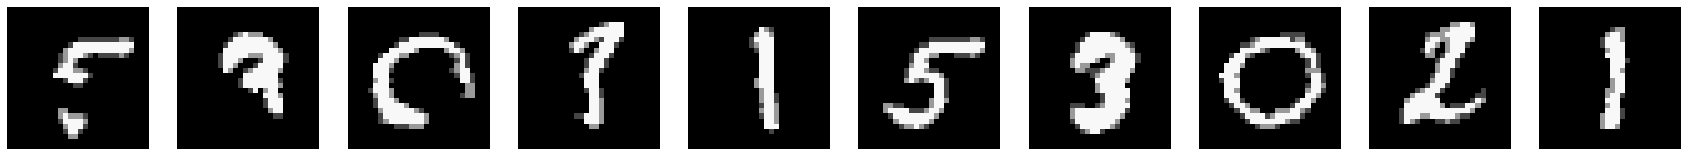

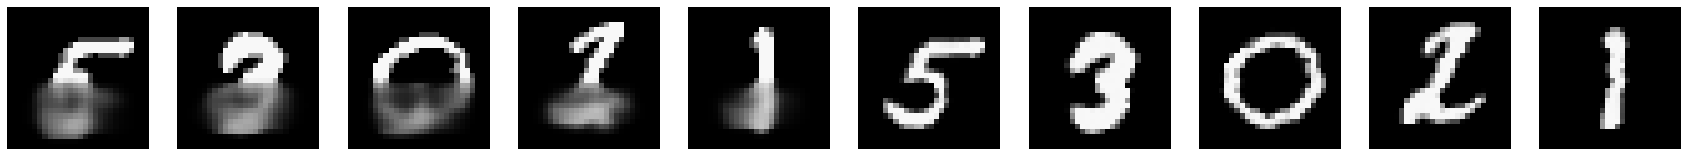

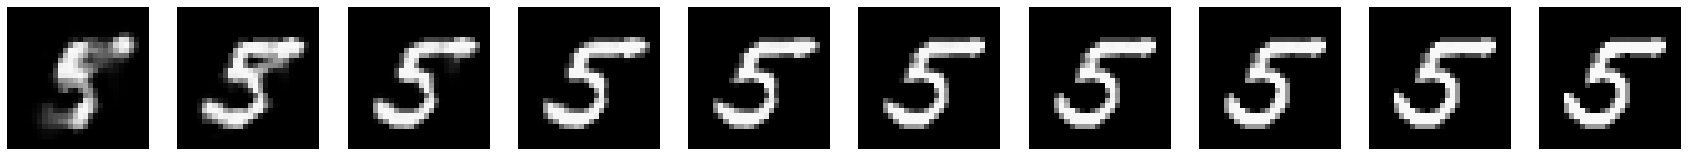

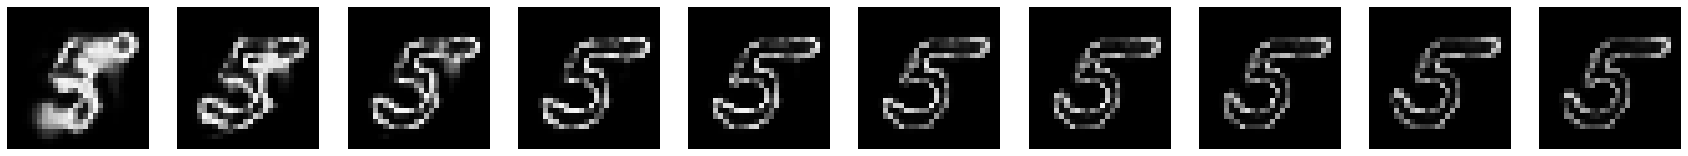

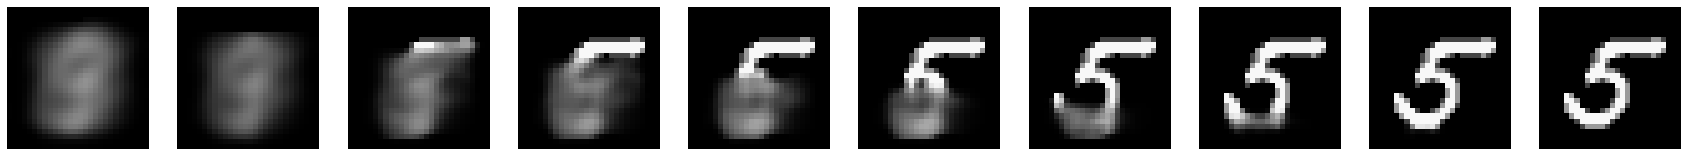

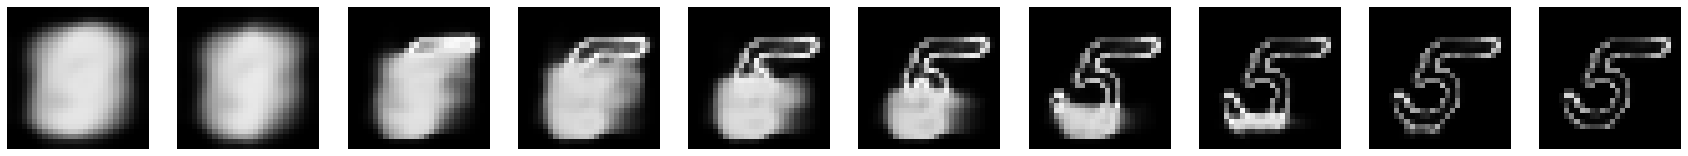

Step 3882, Loss (last minibatch): 0.12640777230262756, Loss (80 step avg.): 0.19979693786597547


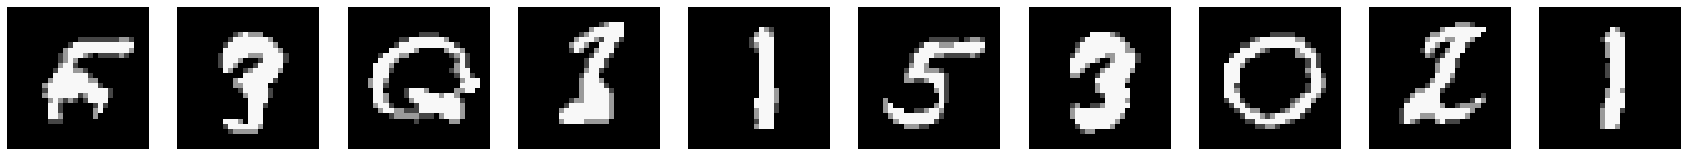

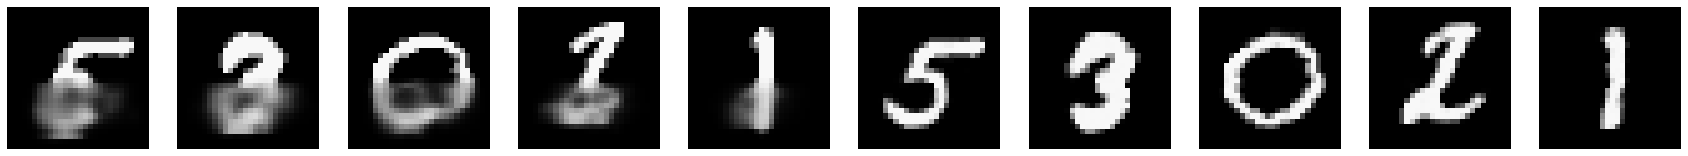

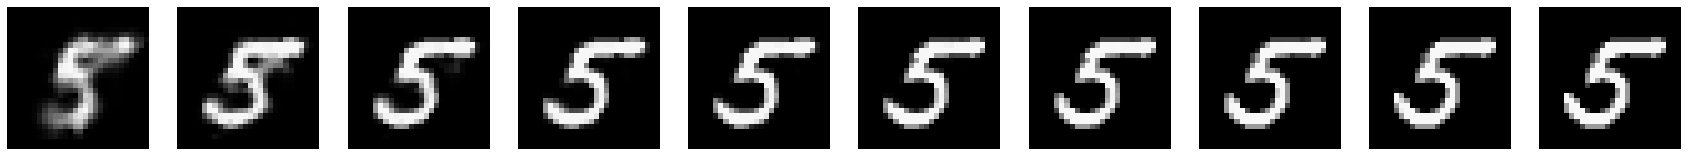

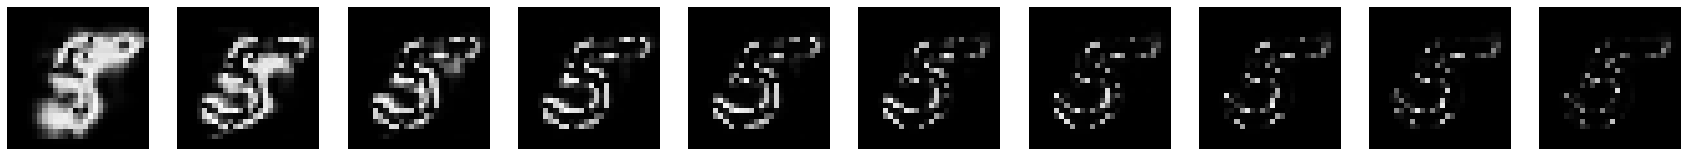

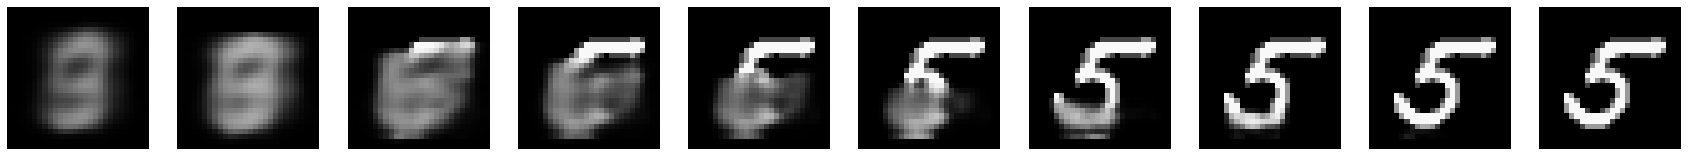

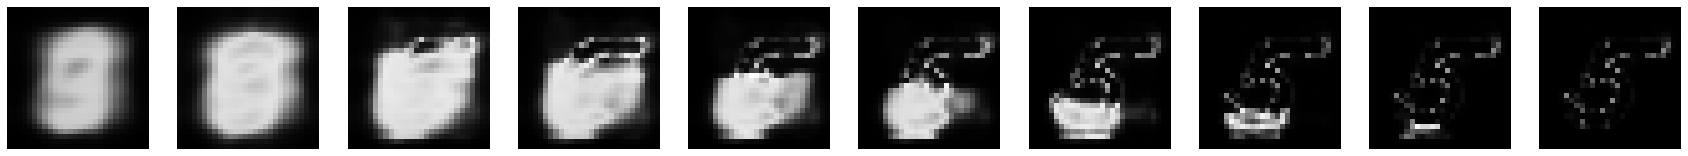

Step 7772, Loss (last minibatch): 0.2162659764289856, Loss (80 step avg.): 0.17890926211336514


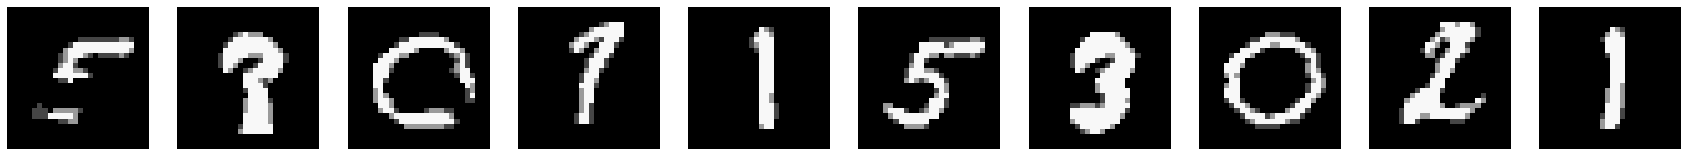

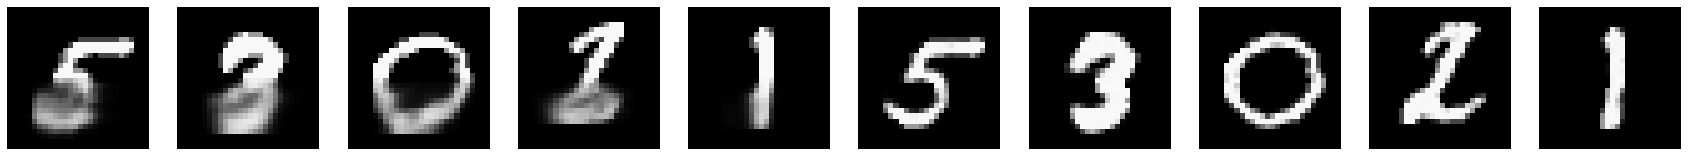

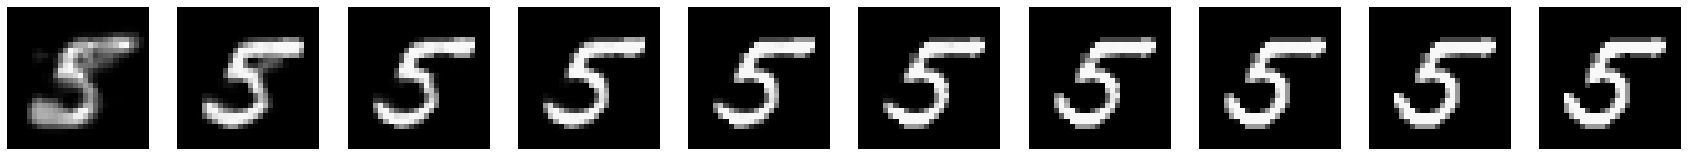

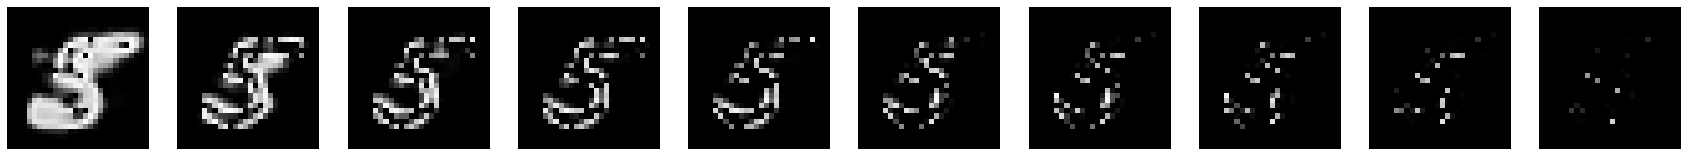

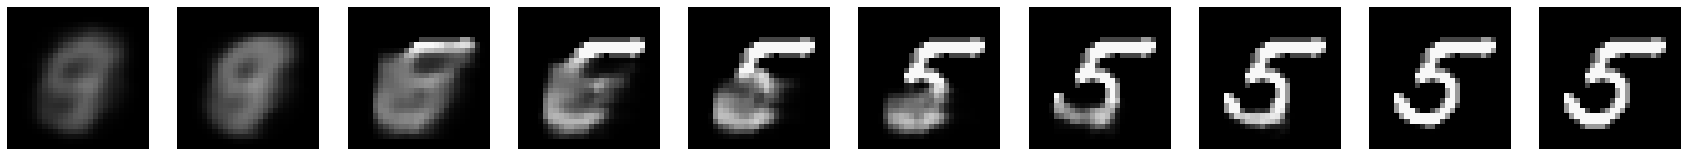

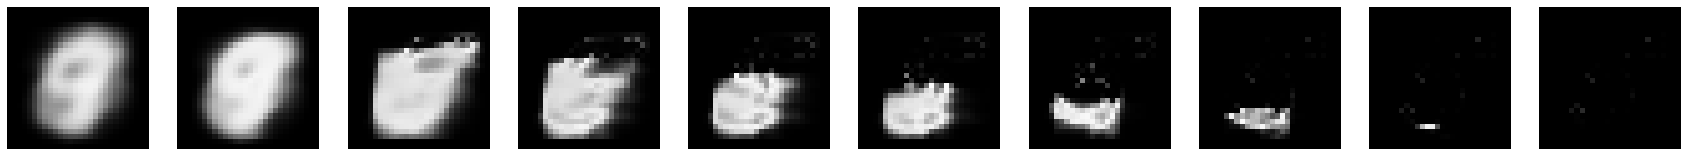

Step 12445, Loss (last minibatch): 0.09547625482082367, Loss (80 step avg.): 0.16091302120023304


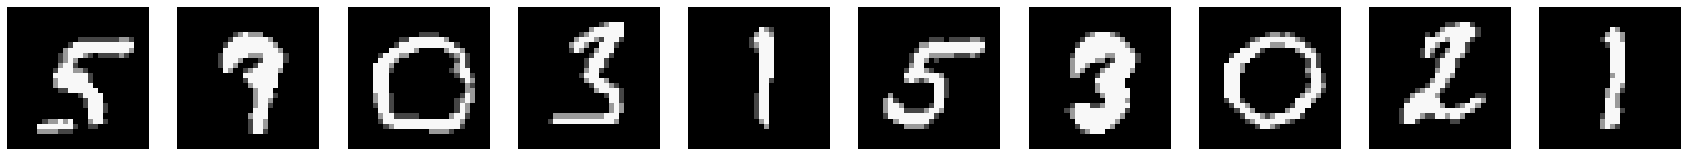

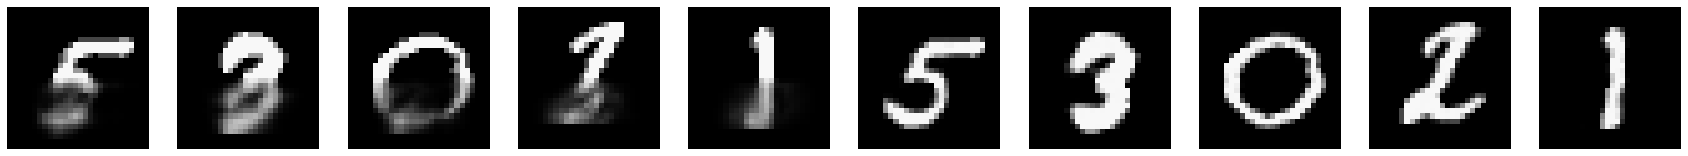

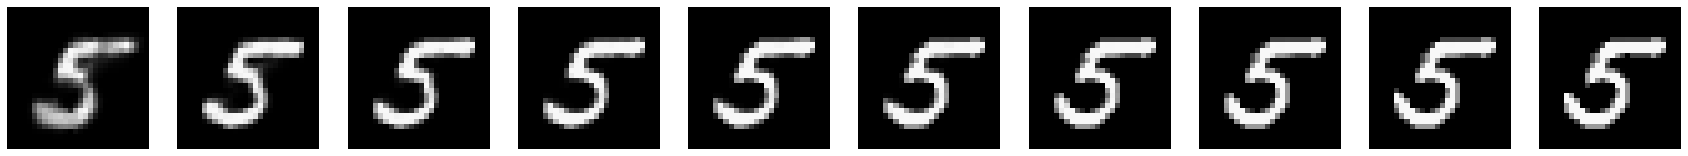

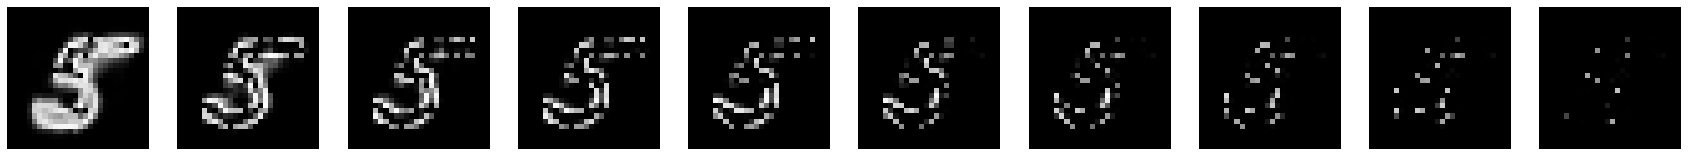

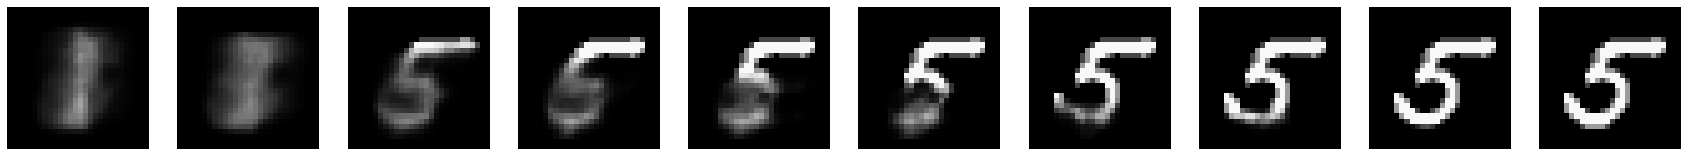

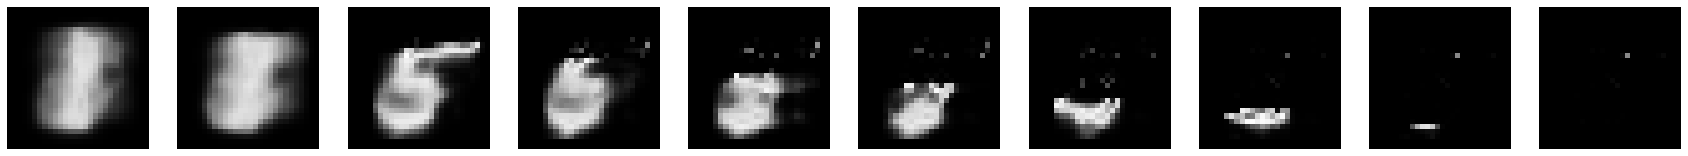

In [ ]:


with strategy.scope():
    training_loop.train()

In [ ]:
model.save(f"models/{model_name}")

In [ ]:
evaler.process_batch(show_input=True)
evaler.new_test_batch()
evaler.process_batch(show_input=True)